<a href="https://colab.research.google.com/github/qusaysellat/Coursera_Capstone/blob/master/Capstone_IBM_Data_Science_Certificate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone IBM Certificate
This notebook is the peer-reviewd project of Coursera's capstone course - IBM data science certificate.

### Important
Folium maps will not display in Github. If you want to view them please go to [nbviewer](https://nbviewer.jupyter.org/) and copy past github link of .ipynb file inside.

# Introduction
Toronto is the provincial capital of Ontario and the most populous city in Canada. It is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.
However, it seems to be very hard for people outside the city to define the main characteristics of each neighborhood inside Toronto that distinguish it from the other neighborhoods.
<br/>
This project analyses the data of Toronto’s various neighborhoods in order to discover the best businesses that can be done in each of the respective neighborhoods by doing a cluster analysis.

# Data Collecting and Pre-processing

In [0]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 

The data needed for the clustering of Toronto’s neighborhoods according to their characteristics can be collected from many sources. We store collected data into Pandas dataframes.

In [0]:
# Data about Toronto’s postcodes, boroughs, and neighborhoods.
# read existing tables in the provided link
neighborhoods = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)

In [3]:
# take the first table as it contains the data we need
neighborhoods=neighborhoods[0]
neighborhoods

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
...,...,...,...
282,M8Z,Etobicoke,Mimico NW
283,M8Z,Etobicoke,The Queensway West
284,M8Z,Etobicoke,Royal York South West
285,M8Z,Etobicoke,South of Bloor


In [0]:
# go with the most common spelling for neighborhood
neighborhoods.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

We notice that some cells under Neighborhoods dataset are Not assigned. For convenience, any row containing Not assigned Borough was dropped. Also, any Not assigned Neighborhood is replaced by the corresponding Borough.

In [5]:
# determine the Not assigned Boroughs in order to ignore them
where_to_ignore = neighborhoods['Borough']!='Not assigned'
where_to_ignore

0      False
1      False
2       True
3       True
4       True
       ...  
282     True
283     True
284     True
285     True
286    False
Name: Borough, Length: 287, dtype: bool

In [6]:
# ignore Not assigned Boroughs
neighborhoods=neighborhoods[where_to_ignore]
neighborhoods

,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
...,...,...,...
281,M8Z,Etobicoke,Kingsway Park South West
282,M8Z,Etobicoke,Mimico NW
283,M8Z,Etobicoke,The Queensway West
284,M8Z,Etobicoke,Royal York South West


In [7]:
# reindex to reflect the change
neighborhoods.reset_index(drop=True, inplace=True)
neighborhoods

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
...,...,...,...
205,M8Z,Etobicoke,Kingsway Park South West
206,M8Z,Etobicoke,Mimico NW
207,M8Z,Etobicoke,The Queensway West
208,M8Z,Etobicoke,Royal York South West


In [8]:
# see if there are Neighborhoods that are Not assigned
uniques = neighborhoods['Neighborhood'].unique()
'Not assigned' in uniques

True

In [0]:
rows, cols = neighborhoods.shape

In [10]:
rows

210

In [11]:
cols

3

In [12]:
# set Not assigned Neighborhoods to the corresponding Borough 
for i in range(rows) :
  if neighborhoods.iloc[i, 2] == 'Not assigned':
    neighborhoods.iloc[i, 2] = neighborhoods.iloc[i, 1]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# check again
uniques = neighborhoods['Neighborhood'].unique()
'Not assigned' in uniques

False

In [14]:
# we have to add place in neighborhoods dataframe to store the coordinates of each neighborhood
# define the new columns
neighborhoods['latitude'] = 0.0
neighborhoods['longitude'] = 0.0
neighborhoods

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Postcode,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,0.0,0.0
1,M4A,North York,Victoria Village,0.0,0.0
2,M5A,Downtown Toronto,Harbourfront,0.0,0.0
3,M6A,North York,Lawrence Heights,0.0,0.0
4,M6A,North York,Lawrence Manor,0.0,0.0
...,...,...,...,...,...
205,M8Z,Etobicoke,Kingsway Park South West,0.0,0.0
206,M8Z,Etobicoke,Mimico NW,0.0,0.0
207,M8Z,Etobicoke,The Queensway West,0.0,0.0
208,M8Z,Etobicoke,Royal York South West,0.0,0.0


In [0]:
rows, cols = neighborhoods.shape

In [16]:
rows

210

In [17]:
cols

5

In [18]:
# Data about the coordinates (latitude and longitude) of various Toronto’s neighborhoods. 
# This data can be collected using Geocoder Python package. 
# However, This package is highly unreliable and I couldn’t use it to download the data. 
# Fortunately, Coursera provided the data via a reliable link. 
# import csv file of the locations as geocoder didn't work
coordinates=pd.read_csv('http://cocl.us/Geospatial_data')
coordinates

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [0]:
coordinates.to_csv('coordinates.csv')

In [0]:
# reindex to use the loc method on the dataframe
coordinates.set_index('Postal Code', inplace=True)

In [21]:
coordinates

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476
...,...,...
M9N,43.706876,-79.518188
M9P,43.696319,-79.532242
M9R,43.688905,-79.554724


In [22]:
# for each Neighborhood, find the lat and lng of it's post code by locating them in coordinates and fill the corresponding cells of neighborhoods
for i in range(rows) :
  postal_code = neighborhoods.iloc[i, 0]
  neighborhoods.loc[i, 'latitude'] = coordinates.loc[postal_code, 'Latitude']
  neighborhoods.loc[i, 'longitude'] = coordinates.loc[postal_code, 'Longitude']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
# the new complete neighborhoods dataframe 
neighborhoods

,Postcode,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763
...,...,...,...,...,...
205,M8Z,Etobicoke,Kingsway Park South West,43.628841,-79.520999
206,M8Z,Etobicoke,Mimico NW,43.628841,-79.520999
207,M8Z,Etobicoke,The Queensway West,43.628841,-79.520999
208,M8Z,Etobicoke,Royal York South West,43.628841,-79.520999


In [24]:
# Data about the various types of venues located in each of the neighborhoods represented in the data collected in the above steps.
# For the purpose of collecting this data, we use FourSquare API.
CLIENT_ID = 'QL0FTK300RYC0NTMNHTH4NUMMAJXC4FRY0FAYIRTV5Y3BWUI' #  Foursquare ID
CLIENT_SECRET = '0TVXWR120LOEHWJLQCMCASWQI33CA01C3AXR4OITKPG4PZIC' #  Foursquare Secret
# CLIENT_ID = 'CPCZ2DSXJ1JEZZUK4LVSDHDXZNW2GRTS2G3JRTPQPJK5NDQC' #  Foursquare ID
# CLIENT_SECRET = 'LCH5S1FHU0QUKISVPVXAD4HAHEEYK2KCC1ZCJUPAL13YQKQP' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QL0FTK300RYC0NTMNHTH4NUMMAJXC4FRY0FAYIRTV5Y3BWUI
CLIENT_SECRET:0TVXWR120LOEHWJLQCMCASWQI33CA01C3AXR4OITKPG4PZIC


In [0]:
# lets define a function that we will use to collect data using FourSquare API
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
# lets find the venues in Toronto
venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['latitude'],
                                   longitudes=neighborhoods['longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights
Lawrence Manor
Queen's Park
Queen's Park
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design Exchange
Toronto 

In [28]:
# there is a limit to how many requests to FourSquare API, so, for experiment convenience I will store the result so I can use whenever I want
# venues.to_csv('venues.csv')
# and then to restreive it
# venues=pd.read_csv('venues.csv')
# venues.drop('Unnamed: 0', 1, inplace=True)
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In order to do the clustering process on the neighborhoods of Toronto, we must first make a dataset that can be fit into a clustering algorithm like KMeans. One approach is to use one-hot encoding to represent each of the returned avenues with the corresponding neighborhoods.

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
len(toronto_onehot.columns)

274

In [30]:
# it seems we have a column with a name 'Neighborhood', this may lead to problems later as we will define a column with the same name
'Neighborhood' in toronto_onehot.columns

True

In [0]:
# so lets change its name slightly
toronto_onehot.rename(columns={"Neighborhood": "neighborhood"}, inplace=True)

In [32]:
# move neighborhood column to the first column
toronto_onehot = pd.concat([venues['Neighborhood'], toronto_onehot], axis=1)
# lets see how our dataframe looks like now
toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,...,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


For each neighborhood, in order to fit the KMeans algorithm, it’s important to know what avenues located in each neighborhood. For this reason we group the one-hot encoded dataset of the avenues by the neighborhood by applying the mean function to represent the importance of each avenue in describing the neighborhood. So the final dataset looks like the following, we will call it Neighborhoods Avenues dataset (because of sparsity nature of data, most entries are zero), and it will be the input of our clustering algorithm.

In [33]:
#let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,...,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.03,0.000000,0.0,0.0,0.00,0.0,0.0,0.03,0.00,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.01,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,Albion Gardens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.100000,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.090909,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.090909,0.0,0.0,0.00,0.0,0.0,0.0,0.0
202,York Mills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.

By this we finished the Data Collecting and Pre-processing phase and prepared our data so that it's good to fit into clustering algorithms. Now, it's good to have some insight about the data before applying our algorithm. That is exactly what we are going to show next.

# Exploratory Data Analysis

Lets examine some statistical properties of each of the datasets we have created.

In [34]:
# neighborhoods and coordinates datasets
print('the shape of Neighborhoods dataset is ', neighborhoods.shape)
print('the shape of Coordinates dataset is ', coordinates.shape)

the shape of Neighborhoods dataset is  (210, 5)
the shape of Coordinates dataset is  (103, 2)


In [35]:
print('columns in Neighborhoods dataset')
neighborhoods.columns

columns in Neighborhoods dataset


Index(['Postcode', 'Borough', 'Neighborhood', 'latitude', 'longitude'], dtype='object')

In [36]:
print('columns in Coordinates dataset, in addition to postcode which is the index')
coordinates.columns

columns in Coordinates dataset, in addition to postcode which is the index


Index(['Latitude', 'Longitude'], dtype='object')

In [37]:
# lets have some insight about Toronto
print('Toronto has {} postcodes, {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Postcode'].unique()),
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

Toronto has 103 postcodes, 11 boroughs and 210 neighborhoods.


As shown above, the 210 neighborhoods of Toronto belong to 11 boroughs and there are 103 distinct postcodes for them.
The coordinates (latitude and longitude) of those postcodes are read into coordinates dataset and used to fill the coordinates in neighborhoods dataset. <br/> 
Now lets draw these neighborhoods on an interactive map using folium library.

In [0]:
# lets retreive location of Toronto
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [39]:
latitude

43.653963

In [40]:
longitude

-79.387207

In [41]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['latitude'], neighborhoods['longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [42]:
# venues dataset
print('the shape of Venues dataset is ', venues.shape)
print('columns in Venues dataset')
venues.columns

the shape of Venues dataset is  (4312, 7)
columns in Venues dataset


Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

In [43]:
# lets have some insight about Venues dataset
print('We have {} neighborhoods and {} types of venues.'.format(
        len(venues['Neighborhood'].unique()),
        len(venues['Venue Category'].unique())
    )
)

We have 206 neighborhoods and 274 types of venues.


In [44]:
# lets be patient and discover the names of different venues we have in Toronto
venues['Venue Category'].unique()

array(['Park', 'Food & Drink Shop', 'Hockey Arena', 'Coffee Shop',
       'Portuguese Restaurant', 'French Restaurant', 'Intersection',
       'Bakery', 'Gym / Fitness Center', 'Spa', 'Breakfast Spot',
       'Restaurant', 'Historic Site', 'Pub', 'Farmers Market',
       'Chocolate Shop', 'Dessert Shop', 'Performing Arts Venue',
       'Mexican Restaurant', 'Café', 'Theater', 'Event Space',
       'Art Gallery', 'Italian Restaurant', 'Yoga Studio',
       'Ice Cream Shop', 'Shoe Store', 'Electronics Store',
       'Cosmetics Shop', 'Asian Restaurant', 'Brewery', 'Bank',
       'Beer Store', 'Hotel', 'Health Food Store', 'Antique Shop',
       'Boutique', 'Furniture / Home Store', 'Vietnamese Restaurant',
       'Clothing Store', 'Accessories Store', 'Fraternity House',
       'Miscellaneous Shop', 'Gym', 'Sushi Restaurant', 'Creperie',
       'Burrito Place', 'Arts & Crafts Store', 'Persian Restaurant',
       'Hobby Shop', 'Diner', 'Japanese Restaurant',
       'Fried Chicken Joint', 

In [45]:
# lets see of 270 venues, what are the most frequent
venues['Venue Category'].value_counts()[0:20]

Coffee Shop             343
Café                    195
Restaurant              115
Pizza Place             114
Bakery                  109
Bar                     106
Italian Restaurant       90
Park                     87
Sandwich Place           81
Hotel                    78
Fast Food Restaurant     70
Clothing Store           66
Japanese Restaurant      64
Gym                      59
American Restaurant      57
Sushi Restaurant         54
Burger Joint             52
Grocery Store            50
Pharmacy                 48
Steakhouse               45
Name: Venue Category, dtype: int64

So, there are 4379 venues of 270 types. Different types of restaurants, playgrouds, bars, shops, transportation stations, .. etc.
We also notice that venues belong to 206 neighborhoods - 4 neighborhoods less than we have in neighborhoods dataset. This is due to the fact that FourSquare API didn't retreive any venues for some neighborhoods. However, the number is very small and will not effect the final result that much and we can continue with the dataset we obtained.

In [46]:
# venues one-hot dataset
print('the shape of One hot dataset is ', toronto_onehot.shape)
print('the shape of Final dataset is ', toronto_grouped.shape)

the shape of One hot dataset is  (4312, 275)
the shape of Final dataset is  (206, 275)


In the initial one-hot dataset, we can imagine that each of the 4379 venues is represented by a 270 vector of 0s and 1s (to indicate venue type) along with an entry filled with the name of the neighborhood the venue belongs to. <br/>
The final dataset is formed by grouping the initial one-hot dataset using the neighborhood attribute and mean method applied. This resulted in a list of each neighborhood in Toronto with its content of venues represented as a number between 0 and 1 - the highest the number, the more the neighborhood contains the respective avenue. <br/>
Lets see what each neighborhood is famous of ..

In [47]:
# Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
             venue  freq
0      Coffee Shop  0.07
1             Café  0.05
2       Steakhouse  0.04
3              Bar  0.04
4  Thai Restaurant  0.04


----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1             Breakfast Spot  0.25
2                     Lounge  0.25
3  Latin American Restaurant  0.25
4         Mexican Restaurant  0.00


----Agincourt North----
                venue  freq
0          Playground   0.5
1                Park   0.5
2   Accessories Store   0.0
3  Mexican Restaurant   0.0
4               Motel   0.0


----Albion Gardens----
                  venue  freq
0           Pizza Place  0.14
1              Pharmacy  0.14
2        Sandwich Place  0.14
3  Fast Food Restaurant  0.14
4            Beer Store  0.14


----Alderwood----
            venue  freq
0     Pizza Place   0.2
1        Pharmacy   0.1
2  Sandwich Place   0.1
3             Gym   0.1
4    Skating Rink   0.1


----Bathurst Manor----
               

In [0]:
# let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
# let's create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,Sushi Restaurant,American Restaurant,Bakery,Burger Joint,Asian Restaurant
1,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,Agincourt North,Park,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,Albion Gardens,Pharmacy,Fried Chicken Joint,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Grocery Store,Gluten-free Restaurant,Department Store,Empanada Restaurant
4,Alderwood,Pizza Place,Coffee Shop,Skating Rink,Gym,Pharmacy,Pub,Athletics & Sports,Sandwich Place,Pool,Dog Run
5,Bathurst Manor,Coffee Shop,Grocery Store,Fast Food Restaurant,Bank,Supermarket,Middle Eastern Restaurant,Sushi Restaurant,Shopping Mall,Restaurant,Fried Chicken Joint
6,Bathurst Quay,Airport Service,Airport Lounge,Harbor / Marina,Coffee Shop,Plane,Boat or Ferry,Airport Terminal,Sculpture Garden,Airport Gate,Airport Food Court
7,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Diner,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
8,Beaumond Heights,Pharmacy,Fried Chicken Joint,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Grocery Store,Gluten-free Restaurant,Department Store,Empanada Restaurant
9,Bedford Park,Italian Restaurant,Coffee Shop,Thai Restaurant,Fast Food Restaurant,Café,Pub,Sushi Restaurant,Restaurant,Butcher,Juice Bar


We may now have a deeper sense that the various kinds of restaurants dominates the venue list. This is a sign that one of our clusters (the cluster which have the neighborhoods with a large number of restaurants like avenues) will dominate other clusters in number of avenues.

# KMeans Clustering

In order to give people good information about the characteristics of each neighborhood, it's good to cluster the neighborhoods into groups and find the characteristics of each group and try to generalize those characteristics to each neighborhood in the cluster.

In [50]:
# Run k-means to cluster the neighborhood into 10 clusters.

# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In next steps, we will add clustering results to the former created dataframes to result in new dataframes : 
<br/>


*   neighborhoods_venues_sorted : we will alter it to also contain cluster labels.
*  toronto_merged : this will be derived from merging neighborhoods dataframe with neighborhoods_venues_sorted dataframe. It contains neighorhoods information along with cluster label and 10 most frequent venues in each neighborhood. 
*   venue_clusters : this will be derived from venues dataframe. For each venue it contains the cluster label for the respective neighborhood.



In [51]:
# Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods.drop('Postcode', 1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head() 

,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,2,Food & Drink Shop,Park,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio
1,North York,Victoria Village,43.725882,-79.315572,0,French Restaurant,Coffee Shop,Hockey Arena,Intersection,Portuguese Restaurant,Yoga Studio,Donut Shop,Diner,Discount Store,Dog Run
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Theater,Yoga Studio
3,North York,Lawrence Heights,43.718518,-79.464763,0,Clothing Store,Accessories Store,Vietnamese Restaurant,Fraternity House,Miscellaneous Shop,Coffee Shop,Furniture / Home Store,Event Space,Boutique,Empanada Restaurant
4,North York,Lawrence Manor,43.718518,-79.464763,0,Clothing Store,Accessories Store,Vietnamese Restaurant,Fraternity House,Miscellaneous Shop,Coffee Shop,Furniture / Home Store,Event Space,Boutique,Empanada Restaurant


In [52]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Adelaide,Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,Sushi Restaurant,American Restaurant,Bakery,Burger Joint,Asian Restaurant
1,0,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,2,Agincourt North,Park,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,0,Albion Gardens,Pharmacy,Fried Chicken Joint,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Grocery Store,Gluten-free Restaurant,Department Store,Empanada Restaurant
4,0,Alderwood,Pizza Place,Coffee Shop,Skating Rink,Gym,Pharmacy,Pub,Athletics & Sports,Sandwich Place,Pool,Dog Run


In [0]:
# lets register the cluster each venue belongs to

# define our new dataframe - venue_clusters and an auxiliary dataframe - temp
venue_clusters = venues
temp = neighborhoods_venues_sorted.set_index('Neighborhood', drop=True)

In [54]:
# venue_clusters dataframe is similar to venues dataframe but with cluster numbers added
venue_clusters['Cluster Labels'] = 0
for i in range(venue_clusters.shape[0]) :
  neighborhood_ = venue_clusters.iloc[i, 0]
  venue_clusters.iloc[i, 7] = temp.loc[neighborhood_, 'Cluster Labels']
venue_clusters.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,2
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,2
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,0
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop,0
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant,0
5,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant,0
6,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection,0
7,Harbourfront,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery,0
8,Harbourfront,43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop,0
9,Harbourfront,43.654260,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center,0


# Result Analysis

In this section, we have to give some analysis of the clustering process we have done. First we have to get an idea of the distribution of neighborhoods and venues among clusters. We will do some plotting to notice this distribution. Then we will use folium library to get an idea of the geographical distribution of different clusters. Finally we will go deeper by showing exactly what venues each cluster is responsible to contain.

In [55]:
# lets discover the number of neighborhoods in each cluster and draw a histogram to explain that
toronto_merged['Cluster Labels'].value_counts()

0    159
2     14
1     11
8      6
3      5
7      4
5      3
4      3
9      2
6      2
Name: Cluster Labels, dtype: int64

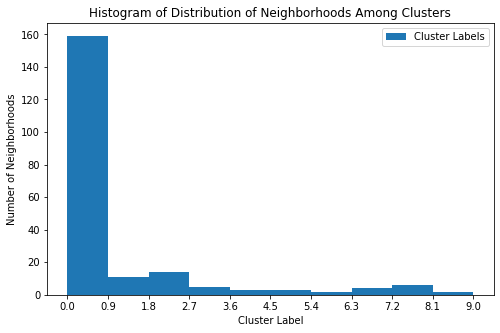

In [56]:
toronto_merged[['Cluster Labels']].plot(kind='hist', figsize=(8, 5), xticks=np.histogram(toronto_merged['Cluster Labels'])[1])

plt.title('Histogram of Distribution of Neighborhoods Among Clusters') # add a title to the histogram
plt.ylabel('Number of Neighborhoods') # add y-label
plt.xlabel('Cluster Label') # add x-label

plt.show()

In [57]:
# lets discover the number of venues in each cluster and draw a histogram to explain that
venue_clusters['Cluster Labels'].value_counts()

0    4183
8      39
2      36
1      20
7      12
4       6
3       5
6       4
9       4
5       3
Name: Cluster Labels, dtype: int64

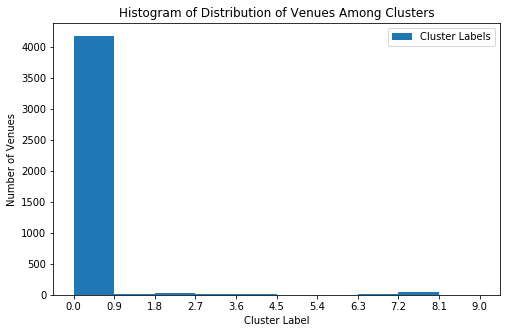

In [58]:
venue_clusters[['Cluster Labels']].plot(kind='hist', figsize=(8, 5), xticks=np.histogram(venue_clusters['Cluster Labels'])[1])

plt.title('Histogram of Distribution of Venues Among Clusters') # add a title to the histogram
plt.ylabel('Number of Venues') # add y-label
plt.xlabel('Cluster Label') # add x-label

plt.show()

As we can see cluster 0 has the biggest number of neighborhoods and venues. This is an indication that Toronto city is very homogeneous in nature of venues. However, there are some neighborhoods that belong to other clusters. We will have a deeper look at this data later. 

In [59]:
# Finally, let's visualize the resulting clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['latitude'], toronto_merged['longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [60]:
# cluster 1

toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,French Restaurant,Coffee Shop,Hockey Arena,Intersection,Portuguese Restaurant,Yoga Studio,Donut Shop,Diner,Discount Store,Dog Run
2,Harbourfront,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Theater,Yoga Studio
3,Lawrence Heights,Clothing Store,Accessories Store,Vietnamese Restaurant,Fraternity House,Miscellaneous Shop,Coffee Shop,Furniture / Home Store,Event Space,Boutique,Empanada Restaurant
4,Lawrence Manor,Clothing Store,Accessories Store,Vietnamese Restaurant,Fraternity House,Miscellaneous Shop,Coffee Shop,Furniture / Home Store,Event Space,Boutique,Empanada Restaurant
5,Queen's Park,Coffee Shop,Gym,Park,Sushi Restaurant,Burrito Place,Restaurant,Burger Joint,Nightclub,Smoothie Shop,Diner
...,...,...,...,...,...,...,...,...,...,...,...
205,Kingsway Park South West,Grocery Store,Bakery,Gym,Convenience Store,Discount Store,Burrito Place,Burger Joint,Sandwich Place,Fast Food Restaurant,Supplement Shop
206,Mimico NW,Grocery Store,Bakery,Gym,Convenience Store,Discount Store,Burrito Place,Burger Joint,Sandwich Place,Fast Food Restaurant,Supplement Shop
207,The Queensway West,Grocery Store,Bakery,Gym,Convenience Store,Discount Store,Burrito Place,Burger Joint,Sandwich Place,Fast Food Restaurant,Supplement Shop
208,Royal York South West,Grocery Store,Bakery,Gym,Convenience Store,Discount Store,Burrito Place,Burger Joint,Sandwich Place,Fast Food Restaurant,Supplement Shop


In [61]:
# cluster 2

toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,Newtonbrook,Home Service,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio,Dim Sum Restaurant
96,Willowdale,Home Service,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio,Dim Sum Restaurant
112,Roselawn,Garden,Home Service,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
197,Humber Bay,Baseball Field,Home Service,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
198,King's Mill Park,Baseball Field,Home Service,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
199,Kingsway Park South East,Baseball Field,Home Service,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
200,Mimico NE,Baseball Field,Home Service,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
201,Old Mill South,Baseball Field,Home Service,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
202,The Queensway East,Baseball Field,Home Service,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
203,Royal York South East,Baseball Field,Home Service,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant


In [62]:
# cluster 3

toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Food & Drink Shop,Park,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio
37,Caledonia-Fairbanks,Park,Women's Store,Market,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Dim Sum Restaurant
59,East Toronto,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
69,CFB Toronto,Airport,Park,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
70,Downsview East,Airport,Park,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
115,Weston,Park,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
154,Agincourt North,Park,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
155,L'Amoreaux East,Park,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
156,Milliken,Park,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
157,Steeles East,Park,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [63]:
# cluster 4

toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Cloverdale,Filipino Restaurant,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,College Stadium
16,Islington,Filipino Restaurant,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,College Stadium
17,Martin Grove,Filipino Restaurant,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,College Stadium
18,Princess Gardens,Filipino Restaurant,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,College Stadium
19,West Deane Park,Filipino Restaurant,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,College Stadium


In [64]:
# cluster 5

toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,Cliffcrest,American Restaurant,Motel,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant
93,Cliffside,American Restaurant,Motel,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant
94,Scarborough Village West,American Restaurant,Motel,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant


In [65]:
# cluster 6

toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Highland Creek,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner
21,Rouge Hill,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner
22,Port Union,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner


In [66]:
# cluster 7

toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Rouge,Fast Food Restaurant,Print Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
8,Malvern,Fast Food Restaurant,Print Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio


In [67]:
# cluster 8

toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
136,Kingsview Village,Pizza Place,Park,Bus Line,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
137,Martin Grove Gardens,Pizza Place,Park,Bus Line,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
138,Richview Gardens,Pizza Place,Park,Bus Line,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
139,St. Phillips,Pizza Place,Park,Bus Line,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [68]:
# cluster 9

toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
78,Clairlea,Bakery,Bus Line,Fast Food Restaurant,Intersection,Bus Station,Soccer Field,Park,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
79,Golden Mile,Bakery,Bus Line,Fast Food Restaurant,Intersection,Bus Station,Soccer Field,Park,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
80,Oakridge,Bakery,Bus Line,Fast Food Restaurant,Intersection,Bus Station,Soccer Field,Park,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
88,Downsview,Basketball Court,Park,Bakery,Construction & Landscaping,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
89,North Park,Basketball Court,Park,Bakery,Construction & Landscaping,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
90,Upwood Park,Basketball Court,Park,Bakery,Construction & Landscaping,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant


In [69]:
# cluster 10

toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
81,Silver Hills,Cafeteria,Martial Arts Dojo,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
82,York Mills,Cafeteria,Martial Arts Dojo,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
